In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime


/home/nsharma/miniconda3/envs/risingverse/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
startTime = datetime.now()

# generating df of anomalies between -5 to 20 in 1101 steps for each year between 2015 to 2100
temp_range = np.linspace(-2, 8.5, 43)
idx = product(range(2020,2301), temp_range) 
temps = np.stack([temp_range for _ in range(2020,2301)]).flatten() 
temps = pd.DataFrame(temps, index=[i for i,x in idx], columns=['temp'])
temps = temps.reset_index().rename(columns={"index":"year"})
# temps # checking things out

In [3]:
# reading the coeffs in SSP2 and SSP3 to obtain damage functions

dataframes = {}

for df in ['nocons_df_old_SSP2', 'nocons_df_old_SSP3', 'nocons_df_old_SSP5', 'nocons_df_new_SSP2', 'nocons_df_new_SSP3', 'nocons_df_new_SSP5', 'mc_df_SSP2', 'mc_df_SSP3', 'mc_df_SSP5']:
    dataframes[df] = pd.read_csv(f'/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SCC_diagnostics/damage_functions/{df}.csv')
    dataframes[df] = dataframes[df][["year", "cons","beta1","beta2"]]
    dataframes[df] = pd.merge(dataframes[df], temps, on= ['year'], how = 'inner') 
    dataframes[df][f'{df}_T'] = (dataframes[df].cons + dataframes[df].temp * dataframes[df].beta1 + dataframes[df].temp**2 * dataframes[df].beta2)

In [4]:
dataframes['mc_df_SSP2']


,year,cons,beta1,beta2,temp,mc_df_SSP2_T
0,2020,0.001451,0.087087,-0.172371,-2.00,-0.862208
1,2020,0.001451,0.087087,-0.172371,-1.75,-0.678838
2,2020,0.001451,0.087087,-0.172371,-1.50,-0.517015
3,2020,0.001451,0.087087,-0.172371,-1.25,-0.376738
4,2020,0.001451,0.087087,-0.172371,-1.00,-0.258008
...,...,...,...,...,...,...
12078,2300,5.021119,-2.431991,1.618202,7.50,77.805049
12079,2300,5.021119,-2.431991,1.618202,7.75,83.366446
12080,2300,5.021119,-2.431991,1.618202,8.00,89.130119
12081,2300,5.021119,-2.431991,1.618202,8.25,95.096067


In [5]:
years = list(range(2020, 2301, 10))

ssp2 = pd.merge(pd.merge(dataframes['nocons_df_old_SSP2'], dataframes['nocons_df_new_SSP2'], on = ['year', 'temp'], how = 'outer'), dataframes['mc_df_SSP2'], on = ['year', 'temp'], how = 'outer')
ssp2 = ssp2[ssp2['year'].isin(years)]

ssp3 = pd.merge(pd.merge(dataframes['nocons_df_old_SSP3'], dataframes['nocons_df_new_SSP3'], on = ['year', 'temp'], how = 'outer'), dataframes['mc_df_SSP3'], on = ['year', 'temp'], how = 'outer')
ssp3 = ssp3[ssp3['year'].isin(years)]

ssp5 = pd.merge(pd.merge(dataframes['nocons_df_old_SSP5'], dataframes['nocons_df_new_SSP5'], on = ['year', 'temp'], how = 'outer'), dataframes['mc_df_SSP5'], on = ['year', 'temp'], how = 'outer')
ssp5 = ssp5[ssp5['year'].isin(years)]

w_cons_old_extrap = pd.merge(pd.merge(dataframes['mc_df_SSP2'], dataframes['mc_df_SSP3'], on = ['year', 'temp'], how = 'outer'), dataframes['mc_df_SSP5'], on = ['year', 'temp'], how = 'outer')
w_cons_old_extrap = w_cons_old_extrap[w_cons_old_extrap['year'].isin(years)]

no_cons_old_extrap = pd.merge(pd.merge(dataframes['nocons_df_old_SSP2'], dataframes['nocons_df_old_SSP3'], on = ['year', 'temp'], how = 'outer'), dataframes['nocons_df_old_SSP5'], on = ['year', 'temp'], how = 'outer')
no_cons_old_extrap = no_cons_old_extrap[no_cons_old_extrap['year'].isin(years)]

no_cons_new_extrap = pd.merge(pd.merge(dataframes['nocons_df_new_SSP2'], dataframes['nocons_df_new_SSP3'], on = ['year', 'temp'], how = 'outer'), dataframes['nocons_df_new_SSP5'], on = ['year', 'temp'], how = 'outer')
no_cons_new_extrap = no_cons_new_extrap[no_cons_new_extrap['year'].isin(years)]

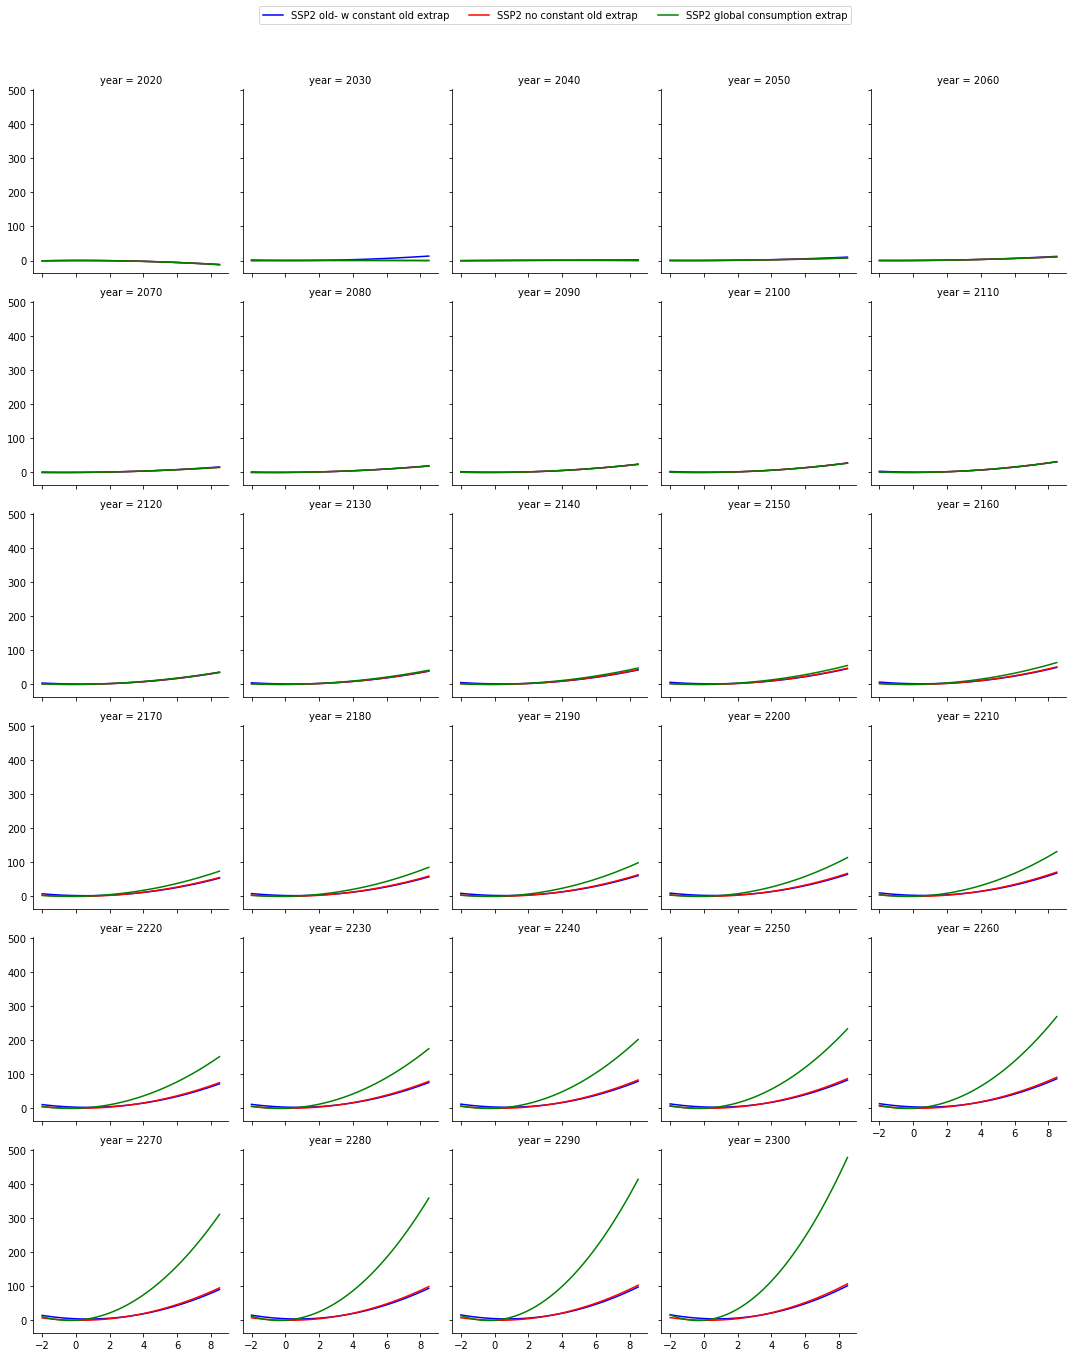

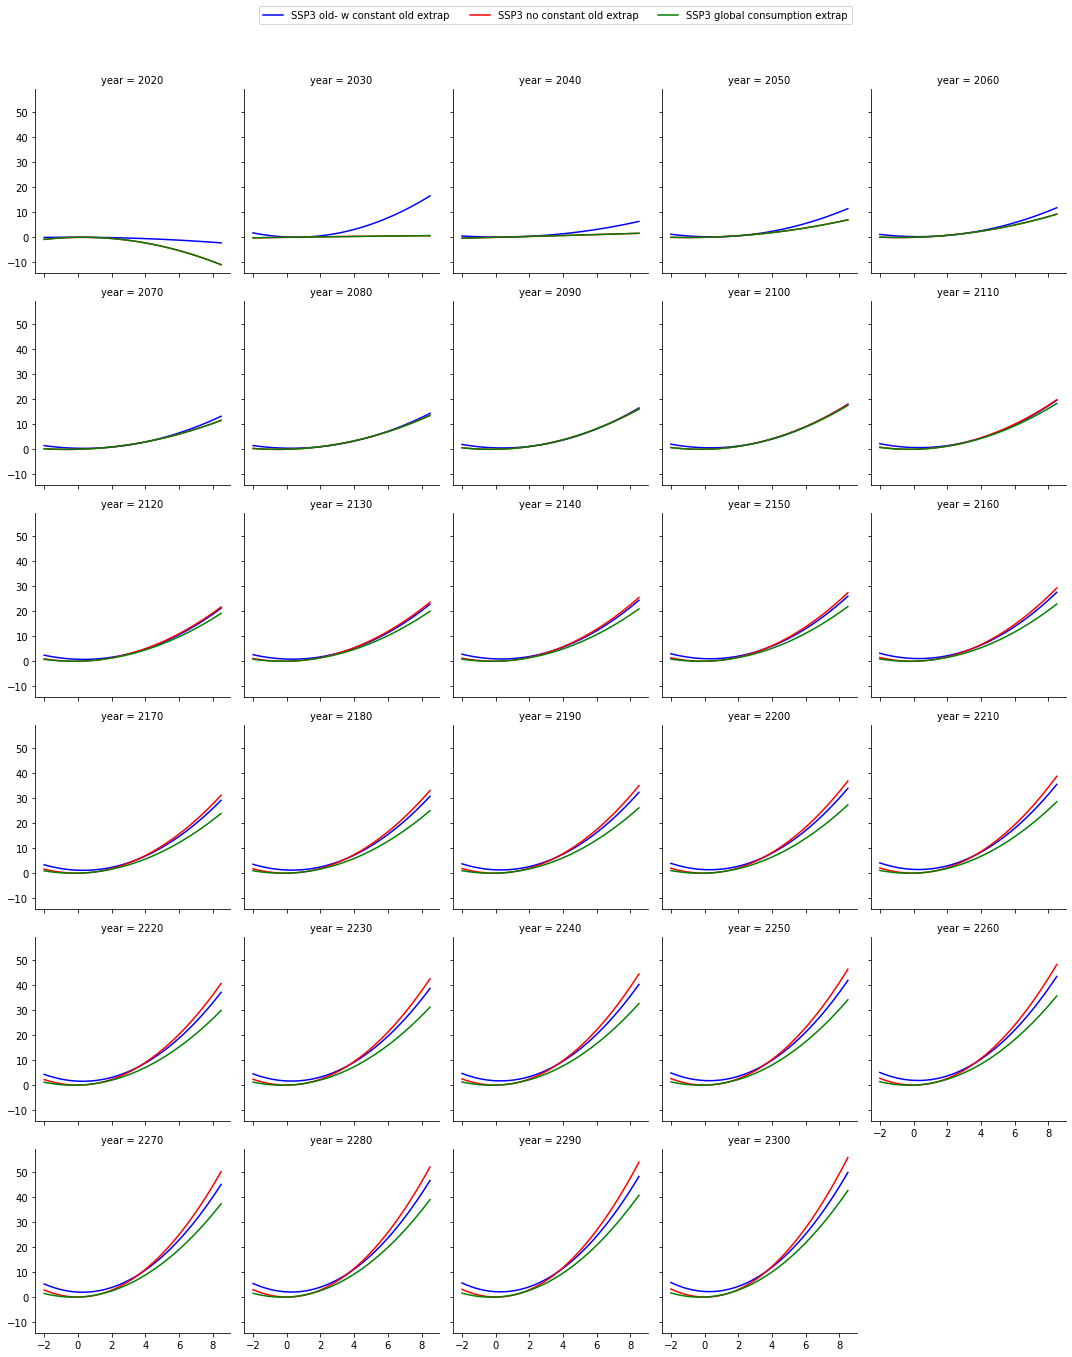

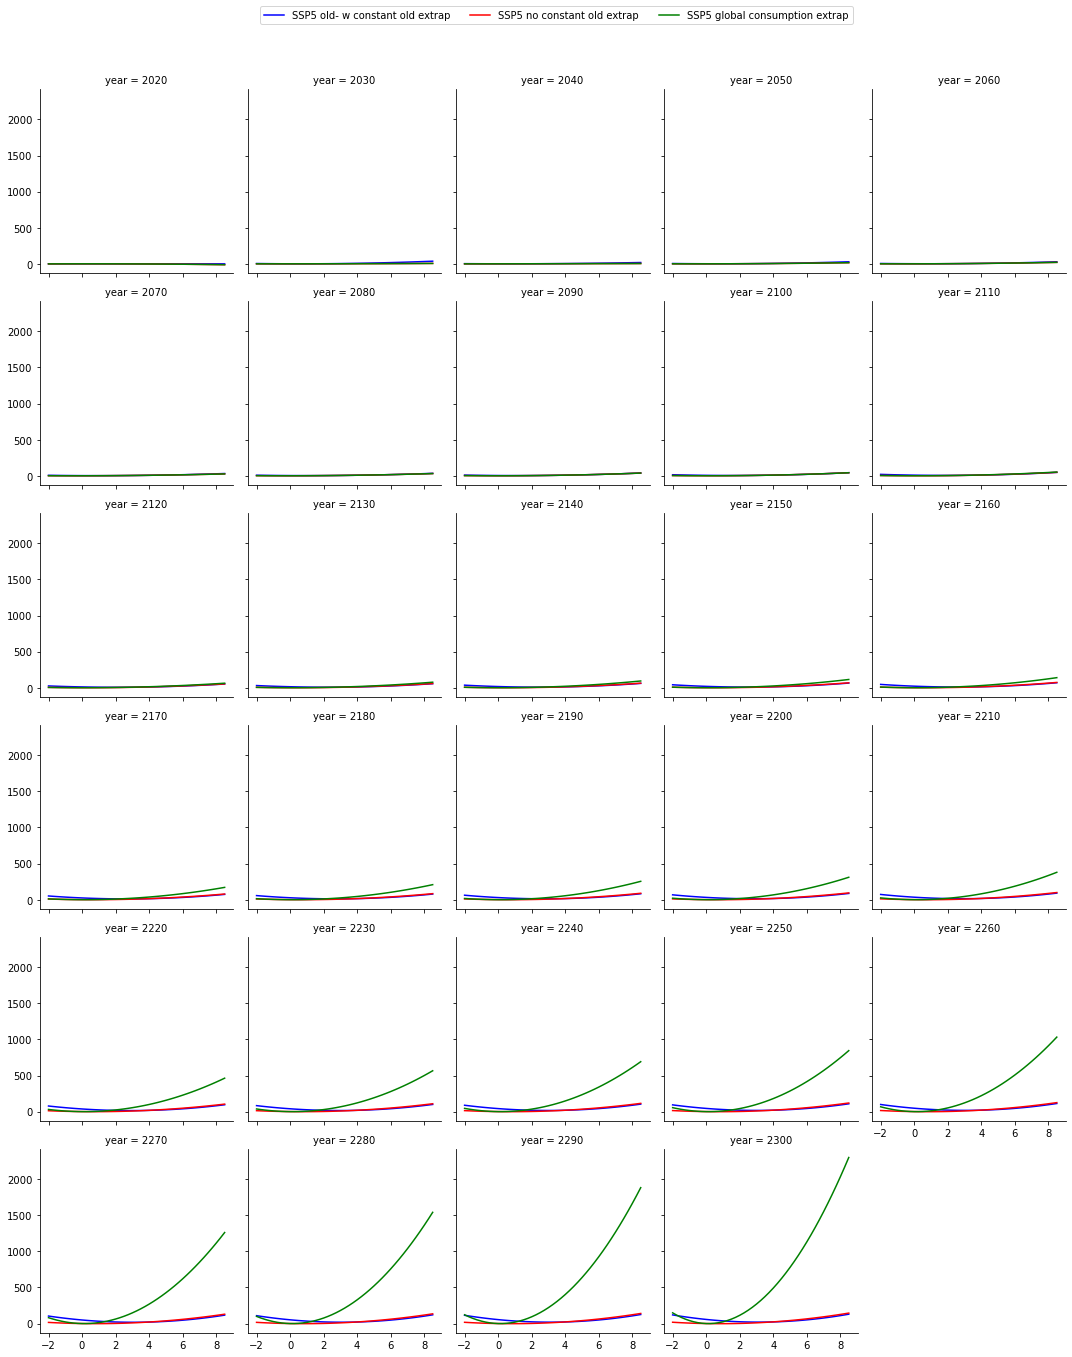

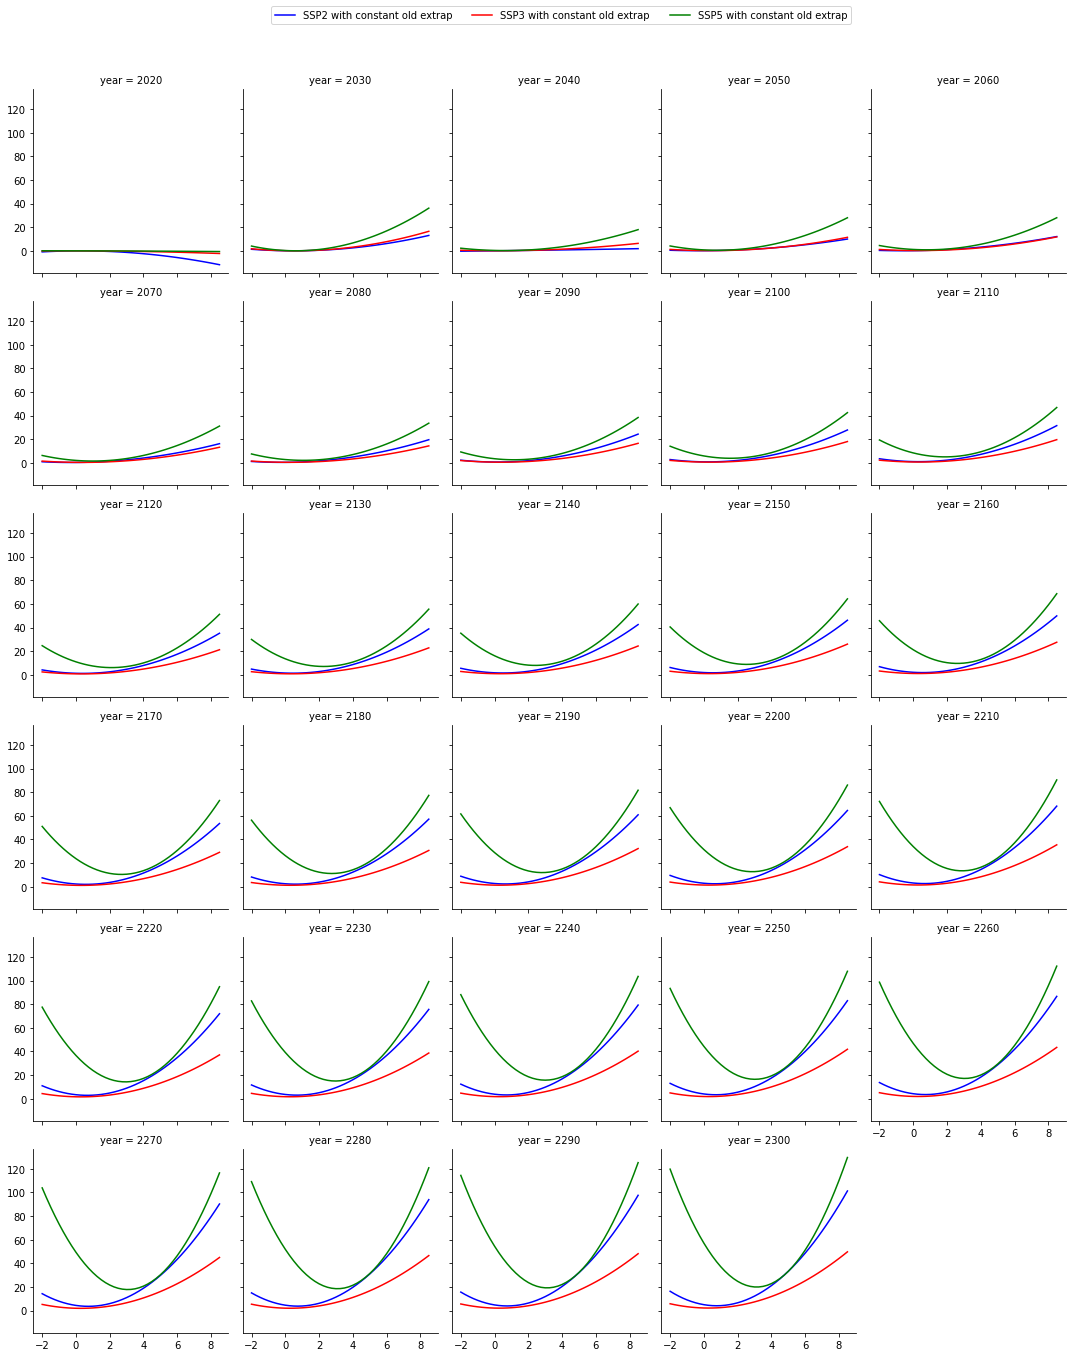

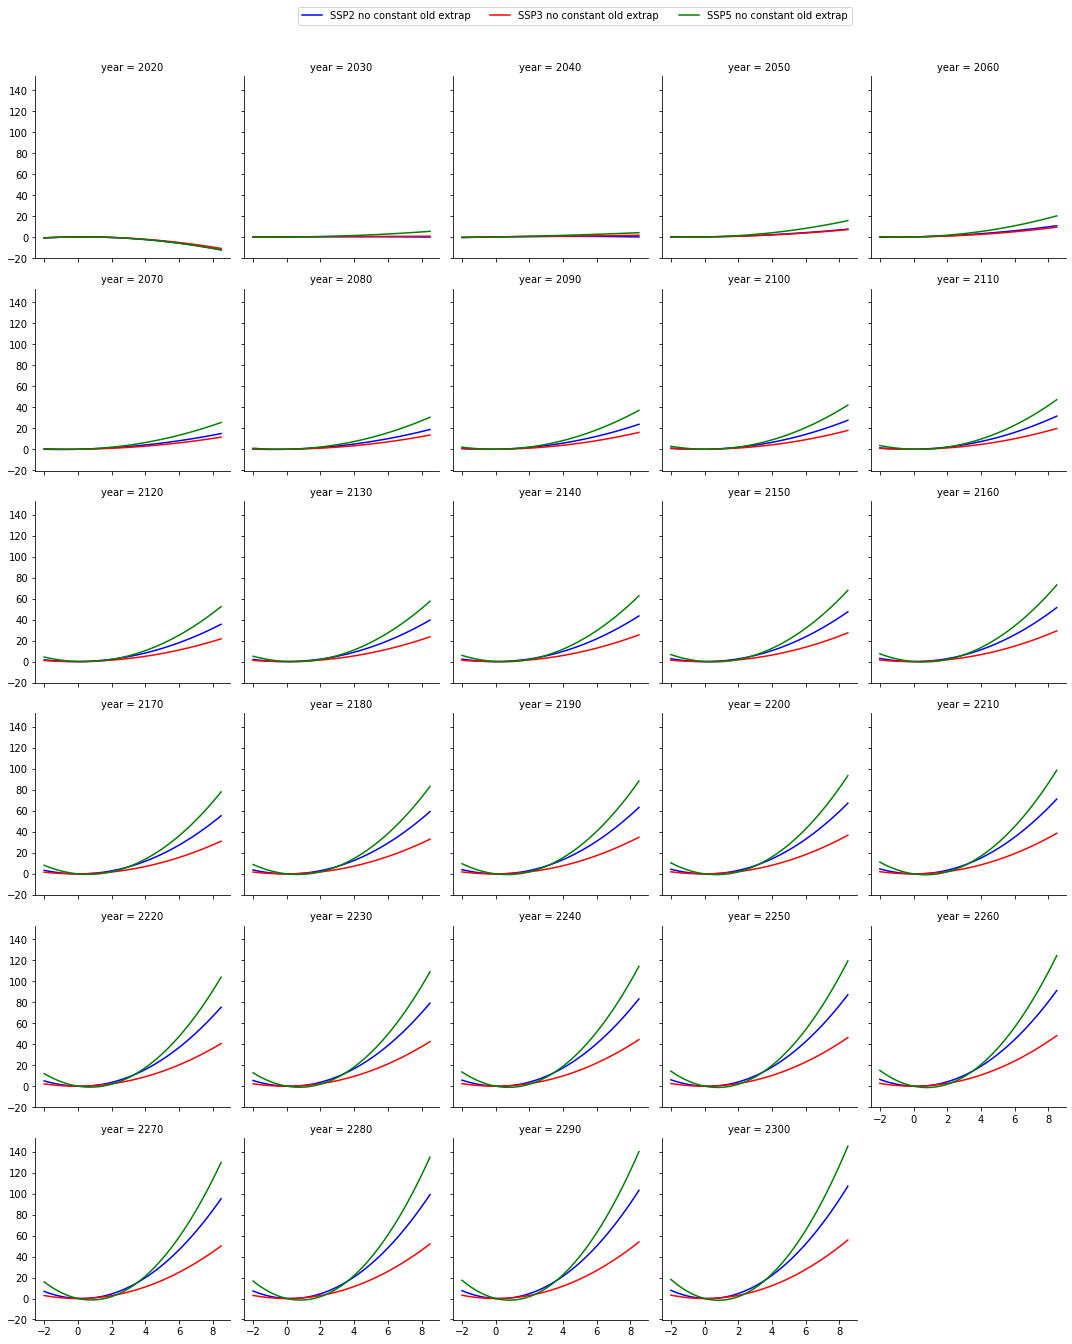

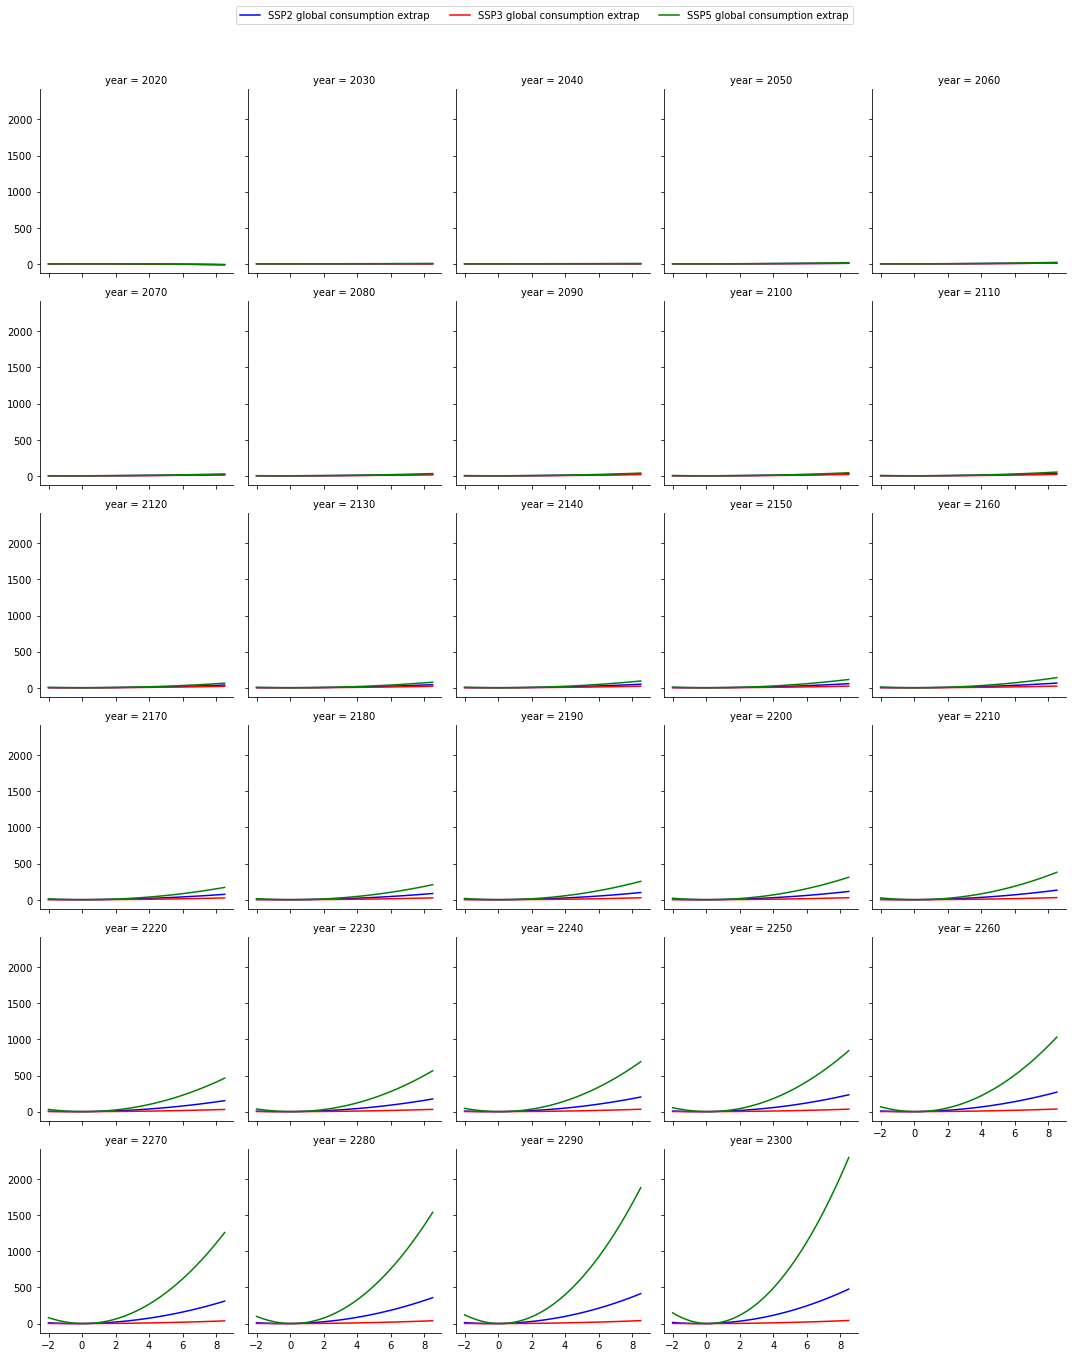

In [8]:
def plot(df, filename, y1, label1, y2, label2, y3, label3, savepath = '/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SCC_diagnostics/plots/'):
   g = sns.FacetGrid(df, col="year", col_wrap=5, sharey=True)
   g.map_dataframe(sns.lineplot, x='temp', y=y1, color = "blue", label=label1)
   g.map_dataframe(sns.lineplot, x='temp', y=y2, color = "red", label=label2)
   g.map_dataframe(sns.lineplot, x='temp', y=y3, color = "green", label=label3)
   lgd = plt.legend(bbox_to_anchor=(1,7.25), ncol=3)
   plt.savefig(f'{savepath}/{filename}', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


plot(ssp2, filename='ssp2_w_mc.pdf', y1 = 'mc_df_SSP2_T', label1 = "SSP2 old- w constant old extrap", y2 = 'nocons_df_old_SSP2_T', label2 = "SSP2 no constant old extrap", y3 = 'nocons_df_new_SSP2_T', label3 = "SSP2 global consumption extrap" )

plot(ssp3, filename='ssp3_w_mc.pdf', y1 = 'mc_df_SSP3_T', label1 = "SSP3 old- w constant old extrap", y2 = 'nocons_df_old_SSP3_T', label2 = "SSP3 no constant old extrap", y3 = 'nocons_df_new_SSP3_T', label3 = "SSP3 global consumption extrap" )

plot(ssp5, filename='ssp5.pdf', y1 = 'mc_df_SSP5_T', label1 = "SSP5 old- w constant old extrap", y2 = 'nocons_df_old_SSP5_T', label2 = "SSP5 no constant old extrap", y3 = 'nocons_df_new_SSP5_T', label3 = "SSP5 global consumption extrap" )

plot(w_cons_old_extrap, filename='w_cons_old_extrap.pdf', y1 = 'mc_df_SSP2_T', label1 = "SSP2 with constant old extrap", y2 = 'mc_df_SSP3_T', label2 = "SSP3 with constant old extrap", y3 = 'mc_df_SSP5_T', label3 = "SSP5 with constant old extrap" )

plot(no_cons_old_extrap, filename='no_cons_old_extrap.pdf', y1 = 'nocons_df_old_SSP2_T', label1 = "SSP2 no constant old extrap", y2 = 'nocons_df_old_SSP3_T', label2 = "SSP3 no constant old extrap", y3 = 'nocons_df_old_SSP5_T', label3 = "SSP5 no constant old extrap" )

plot(no_cons_new_extrap, filename='no_cons_new_extrap.pdf', y1 = 'nocons_df_new_SSP2_T', label1 = "SSP2 global consumption extrap", y2 = 'nocons_df_new_SSP3_T', label2 = "SSP3 global consumption extrap", y3 = 'nocons_df_new_SSP5_T', label3 = "SSP5 global consumption extrap" )


In [9]:
print(datetime.now() - startTime)

0:04:14.082795
